## Meta

#### Settings:


In [ ]:
start_over = False                                   # True will overwrite saved models with new models / False to Lock settings here.
amount_of_symbols_per_action_sample = 3              # Symbols to propose per coin.
# 3^
aggregate_loss_history_epochs = 200                  # Calculate aggregated loss based on last X epochs
minimum_prediction_prob_trade = 0.60                 # Minimum 60% prediciton probability before taking action
trade_when_below_loss = 0.5
binary_target_minimum_increase_min = 0.001      # Minimum 0.1 % increase.
seconds_inbetween = 12                        # Seconds between handling training data.
# 9^, 12
seconds_inbetween_pibeline = 3               # Seconds between cycling the pibeline.

pred_epoch = 20                              # =  4.5  min    | Predict in how many epochs.
# 30^, 20
interval_columns = 70                       # = 22.5  min    | Amount of epochs in history per sample.
# 150^, 100


is_google_colab = False
do_install_dependencies = False
datasets_dir = 'datasets12'


real_wallet_dont_use_euro = 20
do_real_money_trade = False                       # prod: True
# True^
do_training = True                               # prod: True
do_gather_dataset = False                        # prod: False
do_plots = True
model_name_for_trading = 'NNAction'
use_models = {
    'NN': 1, # Neural Network
    'CatBoost': 0,
}


nn_epochs = 5  # Dynamic
nn_learning_rate = 0.000002

catboost_iterations = 7
catboost_depth = 10
catboost_learning_rate = 0.10
catboost_one_hot_max_size = 0
catboost_ctr_target_border_count = 50
catboost_model_size_reg = 0
catboost_max_ctr_complexity = 0
catboost_l2_leaf_reg = None
catboost_min_data_in_leaf = None
catboost_random_strength = None
catboost_bootstrap_type = 'Bernoulli'
catboost_subsample = 0.5
catboost_bagging_temperature = None


### load_models:

In [ ]:
def load_models():
    global models

    if not exists(root_dir):
        os.mkdir(root_dir)
    if not exists(root_dir + '/' + datasets_dir):
        os.mkdir(root_dir + '/' + datasets_dir)

    if use_models["CatBoost"] == 1:
        if not exists(root_dir + '/catboost'):
            os.mkdir(root_dir + '/catboost')

        for filename in os.listdir(root_dir + '/catboost/'):
            if 'ipynb_checkpoints' in filename:
                continue
            models[filename] = joblib.load(root_dir + '/catboost/' + filename)

    if use_models["NN"] == 1:
        if not exists(root_dir + '/nn'):
            os.mkdir(root_dir + '/nn')
            
        for filename in os.listdir(root_dir + '/nn/'):
            if 'ipynb_checkpoints' in filename:
                continue
            models[filename] = tf.keras.models.load_model(root_dir + '/nn/' + filename)


    models = sorted(models.items(), key=lambda x: x[0], reverse=False)
    models = {k: v for k, v in models}

    for model_name, _ in models.items():
        print(model_name + ' loaded!')

### getInitiateFeatures():

In [ ]:
def getInitiateFeatures():
    all_inputs, all_inputs_encoded = [], []

    # vocab = ['BIGGEST_DOWN', 'BIGGER_DOWN', 'BIG_DOWN', 'HALF_DOWN', 'DOWNER', 'DOWN_DOWN', 'DOWN', 'NULL', 'NEUTRAL', 'UP', 'UP_UP', 'HALF_UP', 'BIG_UP', 'BIGGER_UP', 'BIGGEST_UP']
    # normalizer_direction = tf.keras.layers.StringLookup(vocabulary=vocab, output_mode='one_hot')
    normalizer_coin = tf.keras.layers.StringLookup(vocabulary=list(avaiable_coins.keys()), output_mode='one_hot')
    normalizer_symbol = tf.keras.layers.StringLookup(vocabulary=avaiable_symbols_list, output_mode='one_hot')
    normalizer_numeric = tf.keras.layers.Normalization(input_shape=[1,], axis=None)
    normalizer_numeric.adapt([0, 1])                   # TODO: Optimize

    for feature in features_list:        
        dtype, normalizer = None, None

        # if 'direction_' in feature:
        #     dtype, normalizer = "string", normalizer_direction
        if 'symbol' in feature:
            dtype, normalizer = "string", normalizer_symbol
        elif 'coin' in feature:
            dtype, normalizer = "string", normalizer_coin
        else:
            dtype, normalizer = "float32", normalizer_numeric
        
        column = keras.Input(shape=(1,), name = feature, dtype=dtype)
        all_inputs.append(column)
        all_inputs_encoded.append(normalizer(column))
    
    return all_inputs, all_inputs_encoded

### create_models:

In [ ]:
def create_models():
    global did_fit, do_predictions, losses_agregated, losses_agregated_positives

    if len(models.keys()) == 0 or start_over:
        if use_models["NN"] == 1:
            model_name, model = create_model_nn('NNAction')
            models[model_name] = model
            losses_agregated[model_name] = []
            losses_agregated_positives[model_name] = []
            
            # model.summary()
            keras.utils.plot_model(model, show_shapes=True, rankdir="LR")
            print(model_name + ' model created!')

        if use_models["CatBoost"] == 1:
            model_name, model = create_model_catboost('CatBoostAction')
            models[model_name] = model
            losses_agregated[model_name] = []
            losses_agregated_positives[model_name] = []
            print(model_name + ' model created!')

        did_fit = False
        do_predictions = False
    else:
        for model_name in models.keys():
            losses_agregated[model_name] = []
            losses_agregated_positives[model_name] = []


def create_model_nn(name):
    all_inputs, all_inputs_encoded = getInitiateFeatures()
    
    # model = Sequential()
    # model.add(Input(input_shape = (1, amount_of_symbols_per_action_sample, all_features.shape[1])))
    # model.add(Activation('relu'))
    # model.add(Dense(units = 32))
    # model.add(Dropout(0.2))
    # model.add(Dense(units = 10))
    # model.add(Dropout(0.1))
    # model.add(Activation('softmax'))
    # model.add(Dense(units = amount_of_symbols_per_action_sample + 1))
    
    x = layers.concatenate(all_inputs_encoded)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(2048, activation = "relu")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1024, activation = "relu")(x)
    x = layers.Dropout(0.2)(x)
    # x = layers.LSTM(64, activation = "relu", input_shape = (1, all_features.shape[1]), return_sequences = True)(all_features)

    output = layers.Dense(2, activation = 'softmax')(x) # softmax

    # output = tf.keras.layers.CategoryEncoding(num_tokens=amount_of_symbols_per_action_sample + 1, output_mode="multi_hot")(x)
    model = keras.Model(all_inputs, output, name=name)

    model.compile(
        optimizer = keras.optimizers.Adam(
            learning_rate = nn_learning_rate
        ),
        loss = tf.keras.losses.CategoricalCrossentropy(), # SparseCategoricalCrossentropy
    )
    
    return name, model

def create_model_catboost(name):
    param = {
        "iterations": catboost_iterations,
        "depth": catboost_depth,
        'learning_rate': catboost_learning_rate,
        "one_hot_max_size": catboost_one_hot_max_size,
        "ctr_target_border_count": catboost_ctr_target_border_count,
        "model_size_reg": catboost_model_size_reg,
        "max_ctr_complexity": catboost_max_ctr_complexity,
        'l2_leaf_reg': catboost_l2_leaf_reg,
        'min_data_in_leaf': catboost_min_data_in_leaf,
        'random_strength': catboost_random_strength,
        "bootstrap_type": catboost_bootstrap_type,

        "objective": "MultiClass",
        "allow_const_label": True,
        "task_type": "GPU", 
        "has_time": True, 
        "class_names": possible_labels,
        "random_state": 420,
        "allow_writing_files": False,
        "boosting_type": "Plain",
    }
    if catboost_bootstrap_type == "Bayesian":
        param["bagging_temperature"] = catboost_bagging_temperature
    elif catboost_bootstrap_type == "Bernoulli":
        param["subsample"] = catboost_subsample

    model = CatBoostClassifier(**param)

    return name, model
    

### populate_coins_to_pairs:

In [ ]:
def validateActiveTickerSymbol(ticker):
    if float(ticker['lastPrice']) < 0.0000001 or float(ticker['bidPrice']) < 0.0000001 or float(ticker['askPrice']) < 0.0000001:
        return False
    return True
    
def populate_coins_to_pairs():
    global avaiable_coins, avaiable_symbols_list
    avaiable_coins = {}
    avaiable_symbols_list = []

    balances = binance.get_account()['balances']
    tickers = binance.get_ticker() # All symbol info


    for balance in balances:
        coin = balance['asset']
        avaiable_coins[coin] = []

    for ticker in tickers:
        if not validateActiveTickerSymbol(ticker):
            continue
        symbol = ticker['symbol']

        found = False
        for balance in balances:
            coin = balance['asset']
            if isCoinPairMatching(coin, symbol):
              avaiable_coins[coin].append(symbol)
              found = True
        if found:
            avaiable_symbols_list.append(symbol)

def isCoinPairMatching(coin, symbol):
    if coin not in symbol:
        return False
    
    symbols = ["BTCUP", "BTCDOWN", "ADAUP", "ADADOWN", "ETHUP", "ETHDOWN", "DOTUP", "DOTDOWN", "TRXUP", "TRXDOWN", "LINKUP", "LINKDOWN", \
                "BNBUP", "BNBDOWN", "CRH"]
    if any(x in symbol for x in symbols):
        return False

    if coin == 'AMB':
        similars = ["CREAMBUSD", "BEAM"]
        if any(x in symbol for x in similars):
            return False 
    elif coin == 'AUD':
        similars = ["AUDIO"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'TRU':
        similars = ["ASTRUSDT", "USDTRUB", "DOT"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'TUSD':
        similars = ["TUSDT"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'GAL':
        similars = ["GALA"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'BTC':
        similars = ["BTCST"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'OG':
        similars = ["DOGE", "OGN"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'COS':
        similars = ["COCOS"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'RUB':
        similars = ["TRUBTC"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'SHIB':
        similars = ["SUSHIBTC", "SUSHIBUSD", "SUSHIBNB"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'FET':
        similars = ["ELFETH"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'YFI':
        similars = ["YFII"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'TRB':
        similars = ["ASTRBTC", "ASTRBUSD"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'BAR':
        similars = ["HBAR"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'SC':
        similars = ["SCRT"]
        if any(x in symbol for x in similars):
           return False
    elif coin == 'REP':
        similars = ["DREP"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'GO':
        similars = ["AERGO", "ALGO", "DEGO"]
        if any(x in symbol for x in similars):
           return False
    elif coin == 'AST':
        similars = ["ASTR"]
        if any(x in symbol for x in similars):
           return False
    elif coin == 'AST':
        similars = ["CRVETH", "SSVETH"]
        if any(x in symbol for x in similars):
           return False
    elif coin == 'ONE':
        similars = ["AIONETH"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'GLM':
        similars = ["GLMR"]
        if any(x in symbol for x in similars):
           return False
    elif coin == 'DAR':
        similars = ["ADARUB"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'VET':
        similars = ["CRVETH", "SSVETH"]
        if any(x in symbol for x in similars):
           return False
    elif coin == 'OXT':
        similars = ["MBOXTRY"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'ACA':
        similars = ["ALPACA"]
        if any(x in symbol for x in similars):
           return False
    elif coin == 'ONT':
        similars = ["FRONT"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'TCT':
        similars = ["BTCTUSD", "BTTCTRY", "BTCTRY"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'AMP':
        similars = ["RAMP"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'WBTC':
        similars = ["FLOWBTC"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'LPT':
        similars = ["SLPTRY"]
        if any(x in symbol for x in similars):
           return False
    elif coin == 'PHA':
        similars = ["ALPHA"]
        if any(x in symbol for x in similars):
           return False
    elif coin == 'AVA':
        similars = ["KAVA", "AVAX"]
        if any(x in symbol for x in similars):
           return False
    elif coin == 'MOB':
        similars = ["TOMO"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'ORN':
        similars = ["TORN"]
        if any(x in symbol for x in similars):
           return False
    elif coin == 'OM':
        similars = ["OMG", "ATOM", "COMP", "LOOM", "TOMO", "PROM"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'AR':
        similars = ["ARDR", "ARK", "ARPA", "BAR", "FARM", "HARD", "HBAR", "NEAR", "RARE", "DAR", "SPARTA"]
        if any(x in symbol for x in similars):
           return False
    elif coin == 'ATA':
        similars = ["DATA"]
        if any(x in symbol for x in similars):
           return False
    elif coin == 'ANT':
        similars = ["SANTOS"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'WIN':
        similars = ["WING"]
        if any(x in symbol for x in similars):
           return False
    elif coin == 'BUSD':
        similars = ["BNBUSDC", "TRBUSDT", "MOBUSDT"]
        if any(x in symbol for x in similars):
           return False
    elif coin == 'OP':
        similars = ["PEOPLE"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'FOR':
        similars = ["FORTH"]
        if any(x in symbol for x in similars):
            return False
    elif coin == 'CKB':
        similars = ["DOCK", "QUICK"]
        if any(x in symbol for x in similars):
           return False
    elif coin in ['BETH', 'BDOT', 'T']:
        return False

    return True

### initBinanceInfo:

In [ ]:
def initBinanceInfo():
    global binance_symbols

    get_exchange_info = binance.get_exchange_info()
    for symbol in get_exchange_info['symbols']:
        if symbol['symbol'] in avaiable_symbols_list:
            stepSize = 0
            stepSizeInteger = 0
            tickSize = 0
            minNotional = 0
            for filter in symbol['filters']:
                if filter['filterType'] == 'LOT_SIZE':
                    stepSize = float(filter['stepSize'])
                    if filter['stepSize'] == '0.10000000':
                        stepSizeInteger = 1
                    elif filter['stepSize'] == '0.01000000':
                        stepSizeInteger = 2
                    elif filter['stepSize'] == '0.00100000':
                        stepSizeInteger = 3
                    elif filter['stepSize'] == '0.00010000':
                        stepSizeInteger = 4
                    elif filter['stepSize'] == '0.00001000':
                        stepSizeInteger = 5
                    elif filter['stepSize'] == '0.00000100':
                        stepSizeInteger = 6
                    elif filter['stepSize'] == '0.00000010':
                        stepSizeInteger = 7
                    elif filter['stepSize'] == '0.00000001':
                        stepSizeInteger = 8
                elif filter['filterType'] == 'PRICE_FILTER':
                    if filter['tickSize'] == '0.10000000':
                        tickSize = 1
                    elif filter['tickSize'] == '0.01000000':
                        tickSize = 2
                    elif filter['tickSize'] == '0.00100000':
                        tickSize = 3
                    elif filter['tickSize'] == '0.00010000':
                        tickSize = 4
                    elif filter['tickSize'] == '0.00001000':
                        tickSize = 5
                    elif filter['tickSize'] == '0.00000100':
                        tickSize = 6
                    elif filter['tickSize'] == '0.00000010':
                        tickSize = 7
                    elif filter['tickSize'] == '0.00000001':
                        tickSize = 8
                elif filter['filterType'] == 'MIN_NOTIONAL':
                    minNotional = float(filter['minNotional'])

            binance_symbols[symbol['symbol']] = {
                'stepSize': stepSize,
                'stepSizeInteger': stepSizeInteger,
                'tickSize': tickSize,
                'minNotional': minNotional,
            }

### init_meta:

In [ ]:
root_dir = 'models' 
categorial_features = ['symbol', 'coin']    # 'direction_', 

if is_google_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    
    root_dir = 'drive/MyDrive/tradebot'

if is_google_colab or do_install_dependencies:
    !pip install catboost
    !pip install python-binance
    !pip install tensorflow

import os, psutil
from os.path import exists

from catboost import *
import joblib

import warnings
warnings.filterwarnings('ignore')

from binance import Client
from binance.enums import *

import sched, time
import pandas as pd

import time
from threading import Thread, Lock
import numpy as np

import tensorflow as tf
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from tensorflow import keras
from keras import layers
from keras.models import *
from keras.layers import *

import matplotlib.pyplot as plt

from IPython.display import clear_output

models = {}
categorial_features_indices = None
holding_coins = None
features_list = None
features_dtypes = None
avaiable_coins = None
avaiable_symbols_list = None

possible_labels = ['NONE']
for i in range(0, amount_of_symbols_per_action_sample):
    possible_labels.append(str(i))

binance_api_key = 'AoVFfn3JvetSRHpffstx9tg0Zlmzc6WHeAdVjVUnLfbzOTslBanPUMFa7bP4CqtU'
binance_api_secret = 'zNGuMcE2UcycFQeVhTi5o9psM6GjZHvg7gEcTu1f8pazQg42EAMgvma5G583wv4G'
binance = Client(binance_api_key, binance_api_secret)

##### :
epoch, part_epoch, total_part_epochs = 1, 1, 0
memory_data = []
memory_symbols = {}
predictions_saved = []
deleted_symbol_data = 0
print_trained_string = '---'
loss_string = '-'
model_training_lock = None
model_df_buffer_lock = None
handleTickers_lock = None
binance_symbols = {} #
dont_update_holding_coins = []
dont_update_holding_coins_buffer = {}
cancel_orders = False
temp_tickers = {}
do_predictions = True
saved_df_buffer = pd.DataFrame()
saved_y_buffer = []
init_time = None
did_fit = True
losses_agregated = {}
losses_agregated_positives = {}
median_loss = 1
median_loss_positives = 1
time_train = seconds_inbetween - 2
time_big = seconds_inbetween - 2

In [ ]:
### NN:

categorical_encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)
preprocessor = make_column_transformer(
    (categorical_encoder, make_column_selector(dtype_include=object)),
    remainder="passthrough"
)

In [ ]:
populate_coins_to_pairs()
initBinanceInfo()
load_models()
# create_models()

## Functions

### Init:

In [ ]:
def init():
    global holding_coins, do_predictions, model_training_lock, model_df_buffer_lock, \
    epoch, part_epoch, total_part_epochs, memory_data, memory_symbols, predictions_saved, \
    deleted_symbol_data, print_trained_string, loss_string, saved_y_buffer, \
    dont_update_holding_coins, dont_update_holding_coins_buffer, \
    cancel_orders, temp_tickers, saved_df_buffer, \
    handleTickers_lock, init_time

    initBinanceInfo()

    epoch, part_epoch, total_part_epochs = 1, 1, 0
    memory_data = []
    memory_symbols = {}
    predictions_saved = []
    deleted_symbol_data = 0
    print_trained_string = '---'
    loss_string = '-'
    model_training_lock = None
    model_df_buffer_lock = None
    handleTickers_lock = None
    dont_update_holding_coins = []
    dont_update_holding_coins_buffer = {}
    cancel_orders = False
    temp_tickers = {}
    do_predictions = True
    saved_df_buffer = pd.DataFrame()
    saved_y_buffer = []
    init_time = time.time()

    holding_coins = {
        'DEFAULT': {
            'balance': 0,
            'balance_eur': 1,
            'price': 0,
            'counting_epochs': 0,
            'symbol': '',
            'date': time.strftime("%H:%M:%S")
        }
    }

    model_training_lock = Lock()
    model_df_buffer_lock = Lock()
    handleTickers_lock = Lock()

    print("""\
                        ._ o o
                        \_`-)|_
                      ,""       \ 
                    ,"  ## |   = ಠ. 
                  ," ##   ,-\__    `.
                ,"       /     `--._;)
              ,"     ## /
            ,"   ##    /
███████╗████████╗ ██████╗ ███╗   ██╗██╗  ██╗██████╗  ██████╗ ████████╗
██╔════╝╚══██╔══╝██╔═══██╗████╗  ██║██║ ██╔╝██╔══██╗██╔═══██╗╚══██╔══╝
███████╗   ██║   ██║   ██║██╔██╗ ██║█████╔╝ ██████╔╝██║   ██║   ██║   
╚════██║   ██║   ██║   ██║██║╚██╗██║██╔═██╗ ██╔══██╗██║   ██║   ██║   
███████║   ██║   ╚██████╔╝██║ ╚████║██║  ██╗██████╔╝╚██████╔╝   ██║   
╚══════╝   ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚═╝  ╚═╝╚═════╝  ╚═════╝    ╚═╝   v0.3
                                                                      
                    """)
    print()

### Runner:

In [ ]:
def runner():
    global schedule, epoch, part_epoch, total_part_epochs, init_time
    time_now = time.time()
    
    getTickers(part_epoch)

    if part_epoch == (seconds_inbetween / seconds_inbetween_pibeline) - 1:
        thread = Thread(target = updateBinanceBalances)
        thread.start()

    if seconds_inbetween / seconds_inbetween_pibeline <= part_epoch:
        processTickers()
        thread = Thread(target = handleTickers, args = (time_now, epoch, memory_symbols,))
        thread.start()
        epoch += 1
        part_epoch = 0
    part_epoch += 1
    total_part_epochs += 1
    # 459: 6 sec break..
    if total_part_epochs == 460:
        sleepy = (seconds_inbetween_pibeline * total_part_epochs) - (time.time() - init_time) - seconds_inbetween_pibeline + 2.5
        if sleepy < 0:
          sleepy = 0
        print('sleepy', sleepy)
        time.sleep(sleepy)
        init_time = time.time()
        total_part_epochs = 0
        return

    schedule.enter((seconds_inbetween_pibeline * total_part_epochs) - (time.time() - init_time) - seconds_inbetween_pibeline, 1, runner)
    schedule.run()

def getTickers(part_epoch):
  global temp_tickers

  try:
      tickers = binance.get_ticker() # All symbol info
  except:
      print('binance.get_ticker() FAILED 1/2.')
      try:
          tickers = binance.get_ticker() # All symbol info
      except:
          print('binance.get_ticker() FAILED 2/2.')
          return
  
  if part_epoch == 1:
      for symbol in tickers:
          if symbol['symbol'] not in avaiable_symbols_list:
              continue
          temp_tickers[symbol['symbol']] = {
              'symbol': symbol['symbol'],
              'bidPrice_low': float(symbol['bidPrice']),
              'bidPrice_high': float(symbol['bidPrice']),
              'askPrice_low': float(symbol['askPrice']),
              'askPrice_high': float(symbol['askPrice']),
              'volume': float(symbol['volume']),
              'quoteVolume': float(symbol['quoteVolume']),
              'tradeCount': int(symbol['count']),
              'lastPrice': float(symbol['lastPrice']),
          }
        
  else:
      for symbol in tickers:
          if symbol['symbol'] not in avaiable_symbols_list:
              continue
        
          new_bidPrice = float(symbol['bidPrice'])
          new_askPrice = float(symbol['askPrice'])
          
          temp_tickers[symbol['symbol']] = {
              'symbol': symbol['symbol'],
              'bidPrice_low': new_bidPrice if temp_tickers[symbol['symbol']]['bidPrice_low'] > new_bidPrice else temp_tickers[symbol['symbol']]['bidPrice_low'],
              'bidPrice_high': new_bidPrice if temp_tickers[symbol['symbol']]['bidPrice_high'] < new_bidPrice else temp_tickers[symbol['symbol']]['bidPrice_high'],
              'askPrice_low': new_askPrice if temp_tickers[symbol['symbol']]['askPrice_low'] > new_askPrice else temp_tickers[symbol['symbol']]['askPrice_low'],
              'askPrice_high': new_askPrice if temp_tickers[symbol['symbol']]['askPrice_high'] < new_askPrice else temp_tickers[symbol['symbol']]['askPrice_high'],
              'volume': float(symbol['volume']),
              'quoteVolume': float(symbol['quoteVolume']),
              'tradeCount': int(symbol['count']),
              'lastPrice': float(symbol['lastPrice']),
          }
        
          # if new_bidPrice == 0 or new_askPrice == 0:
          #     print(symbol)
          #     del temp_tickers[symbol['symbol']]
          #     del memory_symbols[symbol['symbol']]
          #     avaiable_symbols_list.remove(symbol['symbol'])
          #     print(symbol['symbol'], 'removed.', symbol['bidPrice'], symbol['askPrice'])

def processTickers():
    global memory_symbols
    for coin in temp_tickers.values():
        if coin['symbol'] not in memory_symbols:
            memory_symbols[coin['symbol']] = {
                'bidPrice_low': [],
                'bidPrice_high': [],
                'askPrice_low': [],
                'askPrice_high': [],
                'volume': [],
                'quoteVolume': [],
                'tradeCount': [],
                'lastPrice': [],
            }
        memory_symbols[coin['symbol']]['bidPrice_low'].append(coin['bidPrice_low'])
        memory_symbols[coin['symbol']]['bidPrice_high'].append(coin['bidPrice_high'])
        memory_symbols[coin['symbol']]['askPrice_low'].append(coin['askPrice_low'])
        memory_symbols[coin['symbol']]['askPrice_high'].append(coin['askPrice_high'])
        memory_symbols[coin['symbol']]['volume'].append(coin['volume'])
        memory_symbols[coin['symbol']]['quoteVolume'].append(coin['quoteVolume'])
        memory_symbols[coin['symbol']]['tradeCount'].append(coin['tradeCount'])
        memory_symbols[coin['symbol']]['lastPrice'].append(coin['lastPrice'])


### MAIN Thread:

In [ ]:
def handleTickers(time_now_big, epoch, memory_symbols):
    global memory_data, deleted_symbol_data, print_trained_string, do_predictions, do_predictions, \
    predictions_saved, handleTickers_Lock, categorial_features_indices, features_dtypes, features_list, \
    time_big

    memory_data_symbol = None
    predictions_byModel = [
        {},
        '0',
    ]
    
    handleTickers_lock.acquire() #
    if do_plots and epoch % 3 == 0:
        clear_output(wait=True)
    print('--------  Epoch: ', epoch, '  [' + str(time.strftime("%H:%M:%S")) + ']')
    print()

    # Proccess coin data
    proccessTickers_time = ''
    if epoch > 1:
        # Get list of symbols to check:
        use_symbols = []
        for coin in holding_coins.keys():
            use_symbols += avaiable_coins[coin]
            
        time_big_itcp = time.time() - time_now_big
        time_now = time.time()
        memory_data_symbol = proccessTickers(epoch, memory_symbols, True, use_symbols)
        proccessTickers_time = str(round(time_big_itcp, 2)) + ' + ' + str(round(time.time() - time_now, 2))

    if epoch > pred_epoch:
        # Process Action Data
        time_now = time.time()
        saved, coins = processActionData(memory_data_symbol, True)
        proccessTickers_time += ' + ' + str(round(time.time() - time_now, 2))

        ## Init Set features_dtypes & categorial_features_indices ##
        if epoch == pred_epoch + 1:
            features_list = list(saved[0].keys())
            features_dtypes = {}
            categorial_features_indices = []
            i = 0
            for feature in features_list:
                if any(x in feature for x in categorial_features):
                    categorial_features_indices.append(i)
                i += 1
                if 'symbol' in feature or 'coin' in feature:    #  or 'direction_' in feature
                    features_dtypes[feature] = 'string'
                else:
                    features_dtypes[feature] = 'float32'
        ####

        if do_predictions:
            # Do Predictions:
            predictions_byModel = proccessPredictions(saved, coins)


    # Balances and euro:
    print_eur_string = convert_wallet_to_euro(holding_coins, memory_symbols, epoch)
    print('[ ' + print_eur_string + ' ]   _ Balances:')
    for coin, inner in holding_coins.items():
        print(coin, str(round(inner['balance'], 4)), '', str(round(inner['balance_eur'], 2)) + ' €', '   |  Price: ' + str(inner['price']) + ' ' + inner['symbol'] + '  | Epoch: ' + str(inner['counting_epochs']) + '       [' + inner['date'] + ']')
    print()
    
    # Trade coins:
    if do_predictions and epoch > interval_columns + pred_epoch + 20:
        processTrading(predictions_byModel[0], epoch, memory_symbols)
    #

    # Now build data for the rest of the coins and symbols:
    if epoch > 1:
        time_now_proccessTickers = time.time()
        memory_data_symbol = proccessTickers(epoch, memory_symbols, False, None)
        proccessTickers_time += ' + pT:' + str(round(time.time() - time_now_proccessTickers, 2))

        # Start updating symbol priority list into avaiable_coins:
        thread = Thread(target = updateSymbolPriorityList, args = (memory_data_symbol,))
        thread.start()

    if epoch > pred_epoch:
        time_now_processActionData = time.time()
        memory_data.append(processActionData(memory_data_symbol, False)[0])
        proccessTickers_time += ' + pA:' + str(round(time.time() - time_now_processActionData, 2))
    #
    
    if epoch % pred_epoch == 0 and epoch > pred_epoch + interval_columns:
        do_predictions = True
        
    if epoch > pred_epoch:
        predictions_saved.append(predictions_byModel[0])

        if epoch == pred_epoch + 1:
            print('Attempting to create models now...')
            thread = Thread(target = create_models)
            thread.start()
        else:
            # Do Validation on Past predictions:
            training_list, y_train, validated_list_targets = validatePredictions(epoch, memory_symbols)
            if do_predictions and epoch > interval_columns:
                validatePastPredictions(validated_list_targets)
            
        if epoch == pred_epoch + interval_columns - 5:
            # Do warmup:
            print('Attempting to do warmup now...')
            thread = Thread(target = do_warmup, args = (training_list, y_train,))
            thread.start()

        elif epoch > pred_epoch + interval_columns:
            # Do training:
            thread = Thread(target = trainModels, args = (training_list, y_train,))
            thread.start()

            if do_plots and nn_epochs > 1 and epoch % 3 == 0:
                processPlotting(coins)
    

    # Cleanup:
    if epoch > interval_columns:
        for _, value in memory_symbols.items():
            del value['bidPrice_high'][0]
            del value['bidPrice_low'][0]
            del value['askPrice_high'][0]
            del value['askPrice_low'][0]
            del value['volume'][0]
            del value['quoteVolume'][0]
            del value['tradeCount'][0]
            del value['lastPrice'][0]
        deleted_symbol_data += 1
    if len(memory_data) == pred_epoch:
        del memory_data[0]
        del predictions_saved[0]
    ##
    time_big = round(time.time()-time_now_big, 2)
    print('---------------- ', total_part_epochs, '[', time_big, 's ==', 't: ' + proccessTickers_time, '| p:', predictions_byModel[1], ']', \
          ' || ', print_trained_string, '|  Loss:', loss_string, ' |  RAM:', round(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2), 'mb')
    print()
    print()
    
    handleTickers_lock.release()

### processPlotting():

In [ ]:
def processPlotting(coins):
    plt.figure(1)
    fig = plt.gcf()
    fig.set_size_inches(20, 3)
    found = False
    
    for model_name, losses_agregat in losses_agregated.items():
        if len(losses_agregat) > 0:
            found = True
            plt.plot(losses_agregat, label=model_name + ' Loss', marker='.', linestyle='--', color='b')
    for model_name, losses_agregat in losses_agregated_positives.items():
        if len(losses_agregat) > 0:
            found = True
            plt.plot(losses_agregat, label=model_name + ' Positives', marker='.', linestyle='--', color='orange')
    if found == False:
        return

    plt.axhline(y = 0.5, color = 'gray', linestyle = 'dotted')
    plt.title("Losses last " + str(aggregate_loss_history_epochs) + " epochs for: " + ' - '.join(coins))
    plt.xlabel('Epoch', fontsize=10)
    plt.ylabel('Loss', fontsize=10)
    plt.legend(loc='best')
    plt.ylim(0, 1)
    plt.show()

### proccessTickers():

In [ ]:
def proccessTickers(epoch, memory_symbols, only_use_holding_symbols, use_symbols):
    global highest, lowest

    memory_data_symbol = {}

    for symbol, inner in memory_symbols.items():
        if only_use_holding_symbols and symbol not in use_symbols:
            continue

        dat = {
              'symbol': symbol,                               # categorical
              # 'weekday': str(currentime.weekday() + 1),     # categorical
              # 'hour': str(currentime.hour + 1),             # categorical
        }

        temp_bidPrice_low = inner['bidPrice_low'][epoch - 1 - deleted_symbol_data]
        temp_bidPrice_high = inner['bidPrice_high'][epoch - 1 - deleted_symbol_data]
        temp_askPrice_low = inner['askPrice_low'][epoch - 1 - deleted_symbol_data]
        temp_askPrice_high = inner['askPrice_high'][epoch - 1 - deleted_symbol_data]
        temp_volume = inner['volume'][epoch - 1 - deleted_symbol_data]
        if temp_volume == 0:
            temp_volume = 0.0000001
        temp_quoteVolume = inner['quoteVolume'][epoch - 1 - deleted_symbol_data]
        if temp_quoteVolume == 0:
            temp_quoteVolume = 0.0000001
        temp_tradeCount = inner['tradeCount'][epoch - 1 - deleted_symbol_data]
        if temp_tradeCount == 0:
            temp_tradeCount = 0.0000001
        temp_lastPrice = inner['lastPrice'][epoch - 1 - deleted_symbol_data]
        if temp_lastPrice == 0:
            temp_lastPrice = 0.0000001

        seconds_ago = seconds_inbetween

        for i in range(1, interval_columns + 1):
            seconds_ago_string = str(seconds_ago)
            if (epoch > i):
                index = epoch - i - 1 - deleted_symbol_data
                
                bidPrice_low = inner['bidPrice_low'][index] # Reverse + Pick i element.
                if bidPrice_low == 0:
                    dat['bidPrice_low_' + seconds_ago_string + '_secAgo'] = 0
                else:
                    dat['bidPrice_low_' + seconds_ago_string + '_secAgo'] = (temp_bidPrice_low - bidPrice_low) / bidPrice_low
                    

                bidPrice_high = inner['bidPrice_high'][index] # Reverse + Pick i element.
                if bidPrice_high == 0:
                    dat['bidPrice_high_' + seconds_ago_string + '_secAgo'] = 0
                else:
                    dat['bidPrice_high_' + seconds_ago_string + '_secAgo'] = (temp_bidPrice_high - bidPrice_high) / bidPrice_high

                askPrice_low = inner['askPrice_low'][index] # Reverse + Pick i element.
                if askPrice_low == 0:
                    dat['askPrice_low_' + seconds_ago_string + '_secAgo'] = 0
                else:
                    dat['askPrice_low_' + seconds_ago_string + '_secAgo'] = (temp_askPrice_low - askPrice_low) / askPrice_low

                askPrice_high = inner['askPrice_high'][index] # Reverse + Pick i element.
                if askPrice_high == 0:
                    dat['askPrice_high_' + seconds_ago_string + '_secAgo'] = 0
                else:
                    dat['askPrice_high_' + seconds_ago_string + '_secAgo'] = (temp_askPrice_high - askPrice_high) / askPrice_high

                volume = inner['volume'][index] # Reverse + Pick i element.
                if volume == 0:
                    volume = 0.0000001
                dat['volume_' + seconds_ago_string + '_secAgo'] = (temp_volume - volume) / volume

                quoteVolume = inner['quoteVolume'][index] # Reverse + Pick i element.
                if quoteVolume == 0:
                    quoteVolume = 0.0000001
                dat['quoteVolume_' + seconds_ago_string + '_secAgo'] = (temp_quoteVolume - quoteVolume) / quoteVolume

                tradeCount = inner['tradeCount'][index] # Reverse + Pick i element.
                if tradeCount == 0:
                    tradeCount = 0.0000001
                dat['tradeCount_' + seconds_ago_string + '_secAgo'] = (temp_tradeCount - tradeCount) / tradeCount

                lastPrice = inner['lastPrice'][index] # Reverse + Pick i element.
                if lastPrice == 0:
                    lastPrice = 0.0000001
                dat['lastPrice_' + seconds_ago_string + '_secAgo'] = (temp_lastPrice - lastPrice) / lastPrice

            else:
                dat['bidPrice_low_' + seconds_ago_string + '_secAgo'] = 0
                dat['bidPrice_high_' + seconds_ago_string + '_secAgo'] = 0
                dat['askPrice_low_' + seconds_ago_string + '_secAgo'] = 0
                dat['askPrice_high_' + seconds_ago_string + '_secAgo'] = 0
                dat['volume_' + seconds_ago_string + '_secAgo'] = 0
                dat['quoteVolume_' + seconds_ago_string + '_secAgo'] = 0
                dat['tradeCount_' + seconds_ago_string + '_secAgo'] = 0
                dat['lastPrice_' + seconds_ago_string + '_secAgo'] = 0

            # direction = 'BIGGEST_DOWN'
            # lastPrice = dat['lastPrice_' + seconds_ago_string + '_secAgo']
            # if lastPrice > 3:
            #   direction = 'BIGGEST_UP'
            # elif lastPrice > 2:
            #   direction = 'BIGGER_UP'
            # elif lastPrice > 1:
            #   direction = 'BIG_UP'
            # elif lastPrice > 0.5:
            #   direction = 'HALF_UP'
            # elif lastPrice > binary_target_minimum_increase_min * 2:
            #   direction = 'UP_UP'
            # elif lastPrice > binary_target_minimum_increase_min:
            #   direction = 'UP'
            # elif lastPrice > 0:
            #   direction = 'NEUTRAL'
            # elif lastPrice == 0:
            #   direction = 'NULL'
            # elif lastPrice > -binary_target_minimum_increase_min:
            #   direction = 'DOWN'
            # elif lastPrice > -binary_target_minimum_increase_min * 2:
            #   direction = 'DOWN_DOWN'
            # elif lastPrice > -0.5:
            #   direction = 'DOWNER'
            # elif lastPrice > -1:
            #   direction = 'HALF_DOWN'
            # elif lastPrice > -2:
            #   direction = 'BIG_DOWN'
            # elif lastPrice > -3:
            #   direction = 'BIGGER_DOWN'
            # dat['direction_' + seconds_ago_string + '_secAgo'] = direction

            seconds_ago += seconds_inbetween
            

        memory_data_symbol[symbol] = dat

    return memory_data_symbol

### processActionData():

In [ ]:
def processActionData(memory_data_symbol, only_use_holding_symbols):
    global holding_coins, memory_data, categorial_features_indices, features_list, saved_df_buffer

    saved, coins = [], []

    if only_use_holding_symbols:
        for coin in holding_coins.keys():
            i = 0
            for symbol in avaiable_coins[coin]:
                saved.append(getActionSampleRow(symbol, coin, memory_data_symbol))
                i += 1

            coins.append(coin)
    else:
        for coin in avaiable_coins.keys():
            i = 0
            for symbol in avaiable_coins[coin]:
                saved.append(getActionSampleRow(symbol, coin, memory_data_symbol))
                i += 1

        coins.append(coin)

    return saved, coins


def getActionSampleRow(symbol, coin, memory_data_symbol):
    data = {
        'coin': coin
    }

    if symbol.startswith(coin):
        for attr, value in memory_data_symbol[symbol].items():
            if 'Price_' in attr or 'olume_' in attr or 'tradeCount_' in attr:
                if value != 0:
                    data[attr] = (value * -1) + 0.5
                else:
                    data[attr] = value + 0.5
            else:
                data[attr] = value
    else:
        for attr, value in memory_data_symbol[symbol].items():
            if 'Price_' in attr or 'olume_' in attr or 'tradeCount_' in attr:
                data[attr] = value + 0.5
            else:
                data[attr] = value
    

    return data

def changeDirection(value):
    if value == 'BIGGEST_DOWN':
        return 'BIGGEST_UP'
    if value == 'BIGGER_DOWN':
        return 'BIGGER_UP'
    if value == 'BIG_DOWN':
        return 'BIG_UP'
    if value == 'HALF_DOWN':
        return 'HALF_UP'
    if value == 'DOWNER':
        return 'UP_UP'
    if value == 'DOWN_DOWN':
        return 'UP_UP'
    if value == 'DOWN':
        return 'UP'
    if value == 'NEUTRAL':
        return 'DOWN'
    if value == 'UP':
        return 'DOWN'
    if value == 'UP_UP':
        return 'DOWN_DOWN'
    if value == 'HALF_UP':
        return 'HALF_DOWN'
    if value == 'BIG_UP':
        return 'BIG_DOWN'
    if value == 'BIGGER_UP':
        return 'BIGGER_DOWN'
    if value == 'BIGGEST_UP':
        return 'BIGGEST_DOWN'
    return value

### updateBinanceBalances + updateSymbolPriorityList:

In [ ]:
def updateBinanceBalances():
    global holding_coins, dont_update_holding_coins, cancel_orders

    if cancel_orders:
        cancel_orders = False
        orders = binance.get_open_orders()
        for order in orders:
            print('cancel_order:', binance.cancel_order(
                symbol = order['symbol'],
                orderId = order['orderId']))

    balances = binance.get_account()['balances']

    ### DEBUG:
    balances.append(
        {
            "asset": "BTC",
            "free": "0.03",
    })
    balances.append(
        {
            "asset": "DOGE",
            "free": "1000",
    })
    balances.append(
        {
            "asset": "EUR",
            "free": "440",
    })

    found_assets = []
    for balance in balances:
        balance_number = float(balance['free'])
        if balance_number > 0.0001:
            if balance['asset'] not in holding_coins.keys():
                if 'DEFAULT' in holding_coins.keys():
                    holding_coins[balance['asset']] = holding_coins['DEFAULT'].copy()
                else:
                    continue
            if balance['asset'] == 'EUR':
                balance_number -= real_wallet_dont_use_euro
                if balance_number < 1:
                    continue
            if balance['asset'] == 'BNB':
                balance_number -= 0.01  # 2.76eur 15.09.22
            if balance_number < 0.0001:
                continue
            if balance['asset'] not in dont_update_holding_coins:
                holding_coins[balance['asset']]['balance'] = balance_number
            found_assets.append(balance['asset'])
    for coin in list(holding_coins.keys()):
        if coin not in found_assets or holding_coins[coin]['balance_eur'] < 1:
            if coin in dont_update_holding_coins:
                dont_update_holding_coins.remove(coin)
                del dont_update_holding_coins_buffer[coin]
            del holding_coins[coin]

In [ ]:
def updateSymbolPriorityList(memory_data_symbol):
    global avaiable_coins

    symbol_changes = {}
    for symbol, details in memory_data_symbol.items():
        symbol_changes[symbol] = getPositiveChange(details['bidPrice_high_' + str(seconds_inbetween) + '_secAgo'])
        symbol_changes[symbol] += getPositiveChange(details['askPrice_high_' + str(seconds_inbetween) + '_secAgo'])
        # symbol_changes[symbol] += getPositiveChange(details['volume_' + str(seconds_inbetween) + '_secAgo'])
        # symbol_changes[symbol] += getPositiveChange(details['quoteVolume_' + str(seconds_inbetween) + '_secAgo'])
        # symbol_changes[symbol] += getPositiveChange(details['tradeCount_' + str(seconds_inbetween) + '_secAgo'])
        symbol_changes[symbol] += getPositiveChange(details['lastPrice_' + str(seconds_inbetween) + '_secAgo'])
    symbol_changes = list(dict(sorted(symbol_changes.items(), key=lambda item: item[1], reverse = True)).keys())

    new_avaiable_coins = {}
    for coin, symbols in avaiable_coins.items():
        new_avaiable_coins[coin] = []
        for symbol in symbol_changes:
            if symbol in symbols:
                new_avaiable_coins[coin].append(symbol)

    avaiable_coins = new_avaiable_coins


def getPositiveChange(number):
    if number < 0:
        return number * -1
    else:
        return number

### proccessPredictions():

In [ ]:
def runModelPredictions(model_name, model, df, coins):
  
    if model_name == 'NNAction':
        results = model.predict(dict(df), verbose = 0)
    elif model_name == 'CatBoostAction':
        results = model.predict_proba(df)

    predictions_byModel = {}

    i = 0
    for coin in coins:
        predictions_byModel[coin] = {}
        
        array = []
        sorted_array = []

        for a in range(0, amount_of_symbols_per_action_sample):
            array.append(results[i][1])
            i += 1
        for b in range(a, amount_of_symbols_per_action_sample):
            array.append(0)

        sorted_array = np.argsort(array)

        for a in range(0, amount_of_symbols_per_action_sample):
            predictions_byModel[coin][a] = {
                'symbol': df['symbol'][i - sorted_array[-1 - a] - 1],
                'value': array[sorted_array[-1 - a]],
            }
    
    return predictions_byModel

def proccessPredictions(saved, coins):
    time_now = time.time()
    list_data = []
    predictions_byModel = {}

    coin_count = {}
    total_predictions = 0
    
    for sample in saved:
        if sample['coin'] not in coin_count.keys():
            coin_count[sample['coin']] = 1
        elif coin_count[sample['coin']] >= amount_of_symbols_per_action_sample:
            continue
        else:
            coin_count[sample['coin']] += 1

        list_data.append(list(sample.values()))
        total_predictions += 1

    df = pd.DataFrame(list_data, columns = features_list)

    for model_name, model in models.items():
        predictions_byModel[model_name] = runModelPredictions(model_name, model, df, coins)

    pred_time = str(round(time.time() - time_now, 2)) + 's/' + str(total_predictions) + 'e'

    return predictions_byModel, pred_time

### validatePredictions:

In [ ]:
def validatePredictions(current_epoch, memory_symbols):
    global memory_data, predictions_saved
    
    list_data = []
    y_train = []
    validated_list = {}
    validated_list_targets = {}

    for symbol, inner in memory_symbols.items():
        old_lastPrice = inner['lastPrice'][0]
        if old_lastPrice == 0:
            old_lastPrice = 0.0001
        new_lastPrice = inner['lastPrice'][current_epoch - 1 - deleted_symbol_data]

        validated_list[symbol] = (new_lastPrice - old_lastPrice) / old_lastPrice
        
    for sample in memory_data[0]:
        coin = sample['coin']
        symbol = sample['symbol']

        if coin not in validated_list_targets.keys():
            validated_list_targets[coin] = []

        reg_target = validated_list[symbol]
        if symbol.startswith(coin):
            reg_target *= -1
        if reg_target > binary_target_minimum_increase_min * 2:
            y_result = [0, 1]
            validated_list_targets[coin].append(symbol)
        elif reg_target > binary_target_minimum_increase_min:
            y_result = [0.2, 0.8]
            validated_list_targets[coin].append(symbol)
        elif reg_target >= 0:
            y_result = [0.5, 0.5]
        else:
            y_result = [1, 0]

        list_data.append(sample)
        y_train.append(y_result)

    return list_data, y_train, validated_list_targets

In [ ]:
def validatePastPredictions(validated_list_targets):
    global loss_string, median_loss, median_loss_positives

    loss_string = ''

    for model_name, inner in predictions_saved[0].items():
        # Calculate Loss:
        losses, count = 0, 0
        losses_positives, count_positives = 0, 0

        print('_PAST:')
        for coin, detail in inner.items():
            targets = validated_list_targets[coin]
            targets = list(filter(lambda x: x in [detail[0]['symbol'], detail[1]['symbol'], detail[2]['symbol'], 'NONE'], targets))
            if len(targets) == 0:
                targets = ['NONE']

            print(coin, '_targets:', '  '.join(targets), ' ', ' ', ' ', '_pred: ', detail[0]['symbol'], round(detail[0]['value'], 2), ' ', detail[1]['symbol'], round(detail[1]['value'], 2), ' ', detail[2]['symbol'], round(detail[2]['value'], 2))
            
            found_positive = False
            loss, loss_positive = 1, 1

            if 'NONE' in targets:
                # Loss:
                loss = detail[0]['value']

                # Positives:
                if loss > 0.5:
                    loss_positive = loss
                    found_positive = True
            else:
                loss_positives_temp = 3

                for i in range(0, amount_of_symbols_per_action_sample):
                    if detail[i]['symbol'] in targets:
                        # Loss:
                        loss_positives_temp -= detail[i]['value']

                loss = loss_positives_temp / amount_of_symbols_per_action_sample
                loss_positive = loss
                found_positive = True
                
            if found_positive:
                count_positives += 1
                losses_positives += loss_positive
            count += 1
            losses += loss
        print()
        
        losses /= count

        losses_agregated[model_name].append(losses)

        length_losses_agregated = len(losses_agregated[model_name])
        length_losses_agregated_positives = len(losses_agregated_positives[model_name])

        if count_positives > 0:
            losses_positives /= count_positives
        elif length_losses_agregated_positives > 0:
            losses_positives = losses_agregated_positives[model_name][length_losses_agregated_positives - 1]
        else:
            losses_positives = losses
        losses_agregated_positives[model_name].append(losses_positives)
        length_losses_agregated_positives += 1

        if length_losses_agregated > aggregate_loss_history_epochs:
            del losses_agregated[model_name][0]

        if length_losses_agregated_positives > aggregate_loss_history_epochs:
            del losses_agregated_positives[model_name][0]
        
        median_loss = round(sum(losses_agregated[model_name]) / length_losses_agregated, 3)
        median_loss_positives = round(sum(losses_agregated_positives[model_name]) / length_losses_agregated_positives, 3)

        loss_string += str(median_loss) + ' (P: ' + str(median_loss_positives) + ' )  '
        #

### convert_wallet_to_euro():

In [ ]:
def convert_wallet_to_euro(holding_coins, memory_symbols, epoch):
    global dont_update_holding_coins, dont_update_holding_coins_buffer

    euro = 0

    for coin, data in holding_coins.items():
        found = False
        if coin == 'EUR':
            euro += data['balance']
            holding_coins[coin]['balance_eur'] = data['balance']
            found = True
            continue

        if coin == 'DEFAULT':
            continue
        
        for symbol, inner in memory_symbols.items():
            if symbol in avaiable_coins[coin] and 'EUR' in symbol:
                lastPrice = inner['lastPrice'][epoch - 1 - deleted_symbol_data]
                balance = 0
                if symbol.endswith(coin):
                    balance = data['balance'] / lastPrice
                else:
                    balance = data['balance'] * lastPrice
                    
                euro += balance
                holding_coins[coin]['balance_eur'] = balance
                found = True
                break
        else:
            for symbol in avaiable_coins[coin]:
                lastPrice = memory_symbols[symbol]['lastPrice'][epoch - 1 - deleted_symbol_data]
                similars = ["BTC", "ETH", "BNB", "USDT", "BUSD"]
                if any(x in symbol for x in similars):
                    new_currency = 0
                    if symbol.endswith(coin):
                        new_currency = data['balance'] / lastPrice
                    else:
                        new_currency = data['balance'] * lastPrice
                    new_coin = symbol.replace(coin, '')
                    
                    # print(symbol, coin, new_coin) 
                    for symbol2 in memory_symbols.keys():
                        if symbol2 in avaiable_coins[new_coin] and 'EUR' in symbol2:
                            lastPrice = memory_symbols[symbol2]['lastPrice'][epoch - 1 - deleted_symbol_data]
                            balance = 0
                            if symbol2.endswith(coin):
                                balance = new_currency / lastPrice
                            else:
                                balance = new_currency * lastPrice
                                
                            euro += balance
                            holding_coins[coin]['balance_eur'] = balance
                            found = True
                            break
                    else:
                        continue
                    break

        if found == False:            
          print('ALEED!!: convert_wallet_to_euro() | Couldnt resolve coin for trading euro:', coin)

    return str(round(euro, 2)) + ' €'

### processTrading:

In [ ]:
def processTrading(predictions_byModel, current_epoch, memory_symbols):
    global holding_coins, dont_update_holding_coins, dont_update_holding_coins_buffer, cancel_orders

    print('_TRADING:')
    for inner in predictions_byModel.values():
        for coin, details in inner.items():
            if coin in holding_coins.keys():
                print(coin, details[0]['symbol'], str(round(details[0]['value'] * 100, 2)) + '%')
    print()


    for coin in list(holding_coins.keys()):
        if median_loss > trade_when_below_loss:
            continue
        symbol = predictions_byModel[model_name_for_trading][coin][0]['symbol']
        if holding_coins[coin]['counting_epochs'] > 99:
            print('Will trade ' + coin + ' now because counting_epochs > 99.')
        elif predictions_byModel[model_name_for_trading][coin][0]['value'] < minimum_prediction_prob_trade:
            continue

        buying_coin = symbol.replace(coin, '')

        buying_quantity = None
        price = None

        if symbol.startswith(coin):
            bidPrice_low = memory_symbols[symbol]['bidPrice_low'][current_epoch - 1 - deleted_symbol_data]
            price = bidPrice_low
            buying_quantity = holding_coins[coin]['balance'] * price
        else:
            askPrice_high = memory_symbols[symbol]['askPrice_high'][current_epoch - 1 - deleted_symbol_data]
            price = askPrice_high
            buying_quantity = holding_coins[coin]['balance'] / price

        price = round(price, binance_symbols[symbol]['tickSize'])
        buying_quantity = round(buying_quantity, 7)

        trade = '--> Attempt Trading ' + str(holding_coins[coin]['balance']) + ' ' + coin + ' to ' + str(buying_quantity) + ' ' + buying_coin + \
                ' for ' + str(price) + '        [' + time.strftime("%H:%M:%S") + ']'
        print(trade)

        #########################################################
        #########################################################
        #########################################################
        
        if do_real_money_trade:
              
            side = SIDE_BUY
            order_quantity = buying_quantity
            order_notional = holding_coins[coin]['balance']
            if symbol.endswith(buying_coin):
                side = SIDE_SELL
                order_quantity = holding_coins[coin]['balance']
                order_notional = buying_quantity

            order_quantity = round(order_quantity, binance_symbols[symbol]['stepSizeInteger'])

            if binance_symbols[symbol]['minNotional'] >= order_notional:
                print('minNotional err', coin, binance_symbols[symbol]['minNotional'], order_quantity)
                del holding_coins[coin]
                if coin in dont_update_holding_coins:
                    dont_update_holding_coins.remove(coin)
                    del dont_update_holding_coins_buffer[coin]
                print(coin + ' deleted from trading wallet.')
                continue

            limit_price = format(price, '.' + str(binance_symbols[symbol]['tickSize']) + 'f')
            order_quantity = format(order_quantity, '.' + str(binance_symbols[symbol]['stepSizeInteger']) + 'f')

            print(symbol, side, order_quantity, limit_price)
        
            success = False
            try:
                cancel_orders = True
                order = binance.create_order(
                    symbol=symbol,
                    side=side,
                    type=ORDER_TYPE_LIMIT,
                    timeInForce=TIME_IN_FORCE_GTC,
                    quantity=order_quantity,
                    price=limit_price)
                print(order)
                success = True
            except Exception as e:
                print('create_order err:', e.message)
                if 'insufficient balance' in e.message or 'MIN_NOTIONAL' in e.message:
                    if coin not in dont_update_holding_coins:
                        if coin not in dont_update_holding_coins_buffer.keys():
                            dont_update_holding_coins_buffer[coin] = 1
                        else:
                            dont_update_holding_coins_buffer[coin] += 1
                            if dont_update_holding_coins_buffer[coin] > 2:
                                dont_update_holding_coins.append(coin)
                    else:
                        holding_coins[coin]['balance'] -= binance_symbols[symbol]['stepSize']
            ###
            ########################################################

            if success:
                balance = buying_quantity
                if buying_coin in holding_coins.keys():
                    balance += holding_coins[buying_coin]['balance']

                # Set the new acquired coin:
                holding_coins[buying_coin] = {
                    'balance': balance,
                    'balance_eur': 1, 
                    'price': limit_price,
                    'counting_epochs': 0,
                    'symbol': symbol, 
                    'date': time.strftime('%H:%M:%S')
                }

                if coin in dont_update_holding_coins:
                    dont_update_holding_coins.remove(coin)
                    del dont_update_holding_coins_buffer[coin]

        print()

    for coin in holding_coins.keys():
        holding_coins[coin]['counting_epochs'] += 1

### trainModels:

In [ ]:
def clean_data_for_training_NN(training_list, y_train):
    df = pd.DataFrame(training_list)
    df = df.astype(dtype = features_dtypes)

    # new_data = []
    # for data in training_list:
    #     append = []
    #     for value in data.values():
    #         append.append(value)
    #     new_data.append(append)

    # y_train = pd.get_dummies(y_train)
    # y_train = tf.keras.utils.to_categorical(y_train, num_classes = amount_of_symbols_per_action_sample + 1)

    # print('y_train', y_train)

    train_ds = tf.data.Dataset.from_tensor_slices((dict(df), y_train))
    
    train_ds = train_ds.batch(10000)        # TODO: Remove this shit

    return train_ds

def do_warmup(training_list, y_train):

    if use_models["NN"] == 1:
        time_now = time.time()
        print(0)
        model_name, model = create_model_nn('NNAction')
        print(1)
        train_ds = clean_data_for_training_NN(training_list, y_train)
        print(2)
        model.fit(train_ds,
                epochs = nn_epochs,
                verbose = 1)
        print(model_name, 'Did warmup:', time.time() - time_now)

    if use_models["CatBoost"] == 1:
        time_now = time.time()
        print(0)
        _, model = create_model_catboost('CatBoostAction')
        print(1)
        df = pd.DataFrame(training_list)
        print(2)
        model.fit(df, 
                y_train, 
                cat_features = categorial_features_indices, 
                verbose = True)
        print(model_name, 'Did warmup:', time.time() - time_now)

In [ ]:
def trainModels(training_list, y_train):
    global print_trained_string, saved_df_buffer, saved_y_buffer, time_train, nn_epochs

    time_now = time.time()

    df = pd.DataFrame(training_list)

    if do_gather_dataset:
        model_df_buffer_lock.acquire()
        saved_df_buffer = pd.concat([saved_df_buffer, df])
        saved_y_buffer += y_train
        model_df_buffer_lock.release()

    time_df = time.time() - time_now

    model_training_lock.acquire()
    time_now = time.time()

    if time_train < seconds_inbetween - 1 and time_big < seconds_inbetween - 1:
        nn_epochs += 1
    elif (time_train > seconds_inbetween - 0.5 or time_big > seconds_inbetween - 0.5) and nn_epochs > 0:
        nn_epochs -= 2

    if do_training and nn_epochs > 0:
        if use_models["NN"] == 1:
            train_ds = clean_data_for_training_NN(training_list, y_train)
            for model_name, model in models.items():
                if "NN" in model_name:
                    model.fit(train_ds,
                            epochs = nn_epochs,
                            verbose = 0)
        if use_models["CatBoost"] == 1:
            for model_name, model in models.items():
                if "CatBoost" in model_name:
                    model.fit(df, 
                            y_train, 
                            cat_features = categorial_features_indices, 
                            verbose = False)

    time_train = time.time() - time_now

    model_training_lock.release()

    # if epoch % 23 == 0:
    #     save() # Save models

    print_trained_string = '[Trained ' + str(len(y_train)) + ' [' + str(round(time_df, 2)) + ' + ' + str(round(time_train, 2)) + ' s]  ' + str(nn_epochs) + ' epochs ]'

### save:

In [ ]:
def save():
    global saved_df_buffer, saved_y_buffer
    time_now = time.time()

    if do_training:
        for model_name, model in models.items():
            if "NN" in model_name and use_models["NN"] == 1:
                try:
                    model.save(root_dir + '/nn/' + model_name)
                except Exception as e:
                    print('SAVE FAILED:', model_name)
                    print(e)
            if "CatBoost" in model_name and use_models["CatBoost"] == 1:
                joblib.dump(model, root_dir + '/catboost/' + model_name)

    if do_gather_dataset:
        if model_df_buffer_lock.locked():
            model_df_buffer_lock.acquire() #
            saved_df_buffer = pd.DataFrame()
            saved_y_buffer = []
            model_df_buffer_lock.release() #
            print('Aborted save df.', round(time.time() - time_now, 2), 's')
        else:
            time_string = str(round(time.time()))
            model_df_buffer_lock.acquire() #
            df_import = saved_df_buffer
            saved_df_buffer = pd.DataFrame()
            y_import = saved_y_buffer
            saved_y_buffer = []
            model_df_buffer_lock.release() #
            df_import.to_csv(root_dir + '/' + datasets_dir + '/' + time_string + '.csv', index = False)
            joblib.dump(y_import, root_dir + '/' + datasets_dir + '/' + time_string + '.csv.y')
            print('Saved df to', datasets_dir, '. ', round(time.time() - time_now, 2), 's', '', df_import.shape[0], len(y_import))

        print()

## Main

In [ ]:
# save()

--------  Epoch:  165   [21:19:44]

[ 1018.03 € ]   _ Balances:
ETH 0.0145  17.39 €    |  Price: 0   | Epoch: 54       [20:46:49]
EUR 420.0  420.0 €    |  Price: 0   | Epoch: 54       [20:46:49]
BTC 0.03  484.35 €    |  Price: 0   | Epoch: 54       [20:46:49]
DOGE 1000.0  96.29 €    |  Price: 0   | Epoch: 54       [20:46:49]

_TRADING:
ETH STEEMETH 44.83%
EUR GALEUR 45.5%
BTC NMRBTC 51.19%
DOGE DOGEBTC 44.69%

_PAST:
ETH _targets: NEOETH  BETAETH       _pred:  NEOETH 0.45   BETAETH 0.45   UFTETH 0.39
EUR _targets: NONE       _pred:  GALEUR 0.47   ENJEUR 0.47   XRPEUR 0.46
BTC _targets: NMRBTC       _pred:  NMRBTC 0.5   AGLDBTC 0.49   IOTXBTC 0.42
DOGE _targets: NONE       _pred:  DOGEUSDT 0.46   DOGEBRL 0.46   DOGEBUSD 0.46



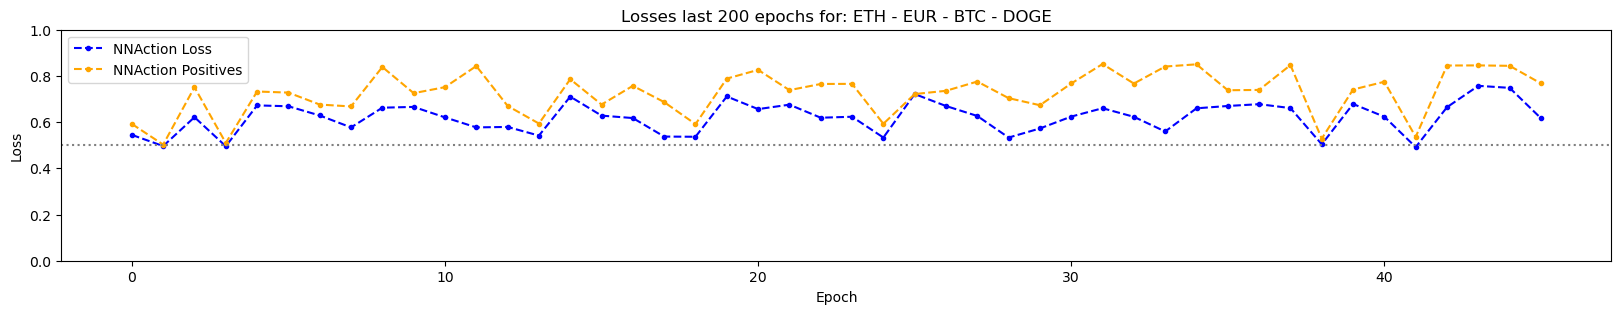

----------------  202 [ 7.48 s == t: 1.71 + 0.26 + 0.18 + pT:0.62 + pA:1.21 | p: 2.65s/12e ]  ||  [Trained 2954 [1.62 + 9.12 s]  4 epochs ] |  Loss: 0.621 (P: 0.727 )    |  RAM: 5938 mb


--------  Epoch:  166   [21:19:55]

[ 1018.04 € ]   _ Balances:
ETH 0.0145  17.39 €    |  Price: 0   | Epoch: 55       [20:46:49]
EUR 420.0  420.0 €    |  Price: 0   | Epoch: 55       [20:46:49]
BTC 0.03  484.36 €    |  Price: 0   | Epoch: 55       [20:46:49]
DOGE 1000.0  96.29 €    |  Price: 0   | Epoch: 55       [20:46:49]

_TRADING:
ETH ADXETH 45.19%
EUR SOLEUR 46.86%
BTC MDXBTC 52.22%
DOGE DOGETRY 47.93%

_PAST:
ETH _targets: SLPETH       _pred:  AXSETH 0.46   SLPETH 0.46   DARETH 0.46
EUR _targets: NONE       _pred:  FTMEUR 0.46   GALAEUR 0.46   GALEUR 0.45
BTC _targets: QUICKBTC  NMRBTC       _pred:  QUICKBTC 0.47   NMRBTC 0.47   ALPACABTC 0.45
DOGE _targets: NONE       _pred:  DOGEUSDT 0.46   DOGEGBP 0.46   DOGETRY 0.44

----------------  205 [ 6.33 s == t: 0.57 + 0.25 + 0.17 + pT:0.65 + pA:1.6

In [27]:
init()
schedule = sched.scheduler(time.time, time.sleep)
while(1):
    runner()
    print('Next episode')


# Last folder size: 26.2mb

# TODO:
# Add volatility indicator per coin/symbol 
#